In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV

# 최대 재귀함수 깊이 설정
import sys
sys.setrecursionlimit(10**7)

# timedelta import
from datetime import timedelta

# datetime import
from datetime import datetime

# go
import plotly.graph_objects as go

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False



In [2]:
df= pd.read_csv('data/price/price_baechoo.csv')

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)
# 구분 컬럼 날짜 컬럼으로 변경
df.rename(columns={'구분':'날짜'}, inplace=True)

# df 날짜 인덱스로 설정
df.set_index('날짜', inplace=True)
df

,가격
날짜,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [3]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df_train = df.loc['2000':'2022-11']
df_test = df.loc['2022-11':'2022-12']

In [4]:
df_test

,가격
날짜,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


In [5]:
df_train

,가격
날짜,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-10-25,8172.0
2022-10-26,8072.0
2022-10-27,8252.0


비 연속적으로 10개 층이 밀리는 방식

In [6]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가','종가','날짜'])

# 비 연속적으로 10일간의 데이터를 하나의 데이터로 만들기 위한 함수
def make_candle(df):
    # 10일간의 데이터를 하나의 데이터로 만들기 위한 변수
    start = 0
    end = 10
    # 10일간의 데이터를 하나의 데이터로 만들기 위한 반복문
    for i in range(len(df)//10):
        # 10일간의 데이터를 하나의 데이터로 만들기 위한 변수
        temp = df.iloc[start:end]
        # 10일간의 데이터를 하나의 데이터로 만들기 위한 변수
        start += 10
        end += 10
        # 10일간의 데이터를 하나의 데이터로 만들기 위한 변수
        open_price = temp.iloc[0]['가격']
        high_price = temp['가격'].max()
        low_price = temp['가격'].min()
        close_price = temp.iloc[-1]['가격']
        date = temp.iloc[-1].name
        # 10일간의 데이터를 하나의 데이터로 만들기 위한 변수
        candle_df.loc[len(candle_df)] = [open_price, high_price, low_price, close_price, date]

    return candle_df

# train 데이터를 10일간의 데이터를 하나의 데이터로 만들기 위한 함수
make_candle(df_train)

candle_df


,시가,고가,저가,종가,날짜
0,5600.0,5790.0,5600.0,5630.0,2000-01-13
1,5630.0,5910.0,5630.0,5910.0,2000-01-25
2,5930.0,6970.0,5930.0,6970.0,2000-02-08
3,7230.0,8690.0,7230.0,8370.0,2000-02-19
4,8030.0,8030.0,7430.0,7630.0,2000-03-03
...,...,...,...,...,...
581,16160.0,23800.0,15480.0,23800.0,2022-08-30
582,24800.0,37800.0,24800.0,33140.0,2022-09-15
583,31920.0,36920.0,23520.0,23520.0,2022-09-29
584,22620.0,23500.0,10623.0,10623.0,2022-10-17


In [7]:
# candle_df 5번째 컬럼을 인덱스로 설정
candle_df.set_index(candle_df.columns[4], inplace=True)

# "종가 shift" 컬럼 생성
candle_df['종가_shift'] = candle_df['종가'].shift(-1)

candle_df

,시가,고가,저가,종가,종가_shift
날짜,,,,,
2000-01-13,5600.0,5790.0,5600.0,5630.0,5910.0
2000-01-25,5630.0,5910.0,5630.0,5910.0,6970.0
2000-02-08,5930.0,6970.0,5930.0,6970.0,8370.0
2000-02-19,7230.0,8690.0,7230.0,8370.0,7630.0
2000-03-03,8030.0,8030.0,7430.0,7630.0,7990.0
...,...,...,...,...,...
2022-08-30,16160.0,23800.0,15480.0,23800.0,33140.0
2022-09-15,24800.0,37800.0,24800.0,33140.0,23520.0
2022-09-29,31920.0,36920.0,23520.0,23520.0,10623.0


In [8]:
# candle_df의 마지막 행만 저장 하여 candle_df_last에 저장
candle_df_last = candle_df.iloc[-1:]

# 종가_shift 컬럼을 삭제
candle_df_last.drop('종가_shift', axis=1, inplace=True)

# candle_df_last 인덱스 삭제
# candle_df_last.reset_index(drop=True, inplace=True)

candle_df_last

/var/folders/j8/f1430hks1c3614dx_6f_f4h00000gn/T/ipykernel_15738/2825472735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candle_df_last.drop('종가_shift', axis=1, inplace=True)


,시가,고가,저가,종가
날짜,,,,
2022-10-31,9706.0,9706.0,7792.5,7792.5


In [9]:
# candle_df copy
candle_df_copy = candle_df.copy()

# candle_df_copy 결측치 제거
candle_df_copy.dropna(inplace=True)

In [10]:
# 캔들 스틱 차트 그리기
def candle_stick_chart(df):
    # 캔들 스틱 차트 그리기
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['시가'], high=df['고가'],
                    low=df['저가'], close=df['종가'])])

    # 캔들 스틱 차트 그리기
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

# 캔들 스틱 차트 그리기
candle_stick_chart(candle_df_copy)

<AxesSubplot:title={'center':'Person Correlation of Features'}>

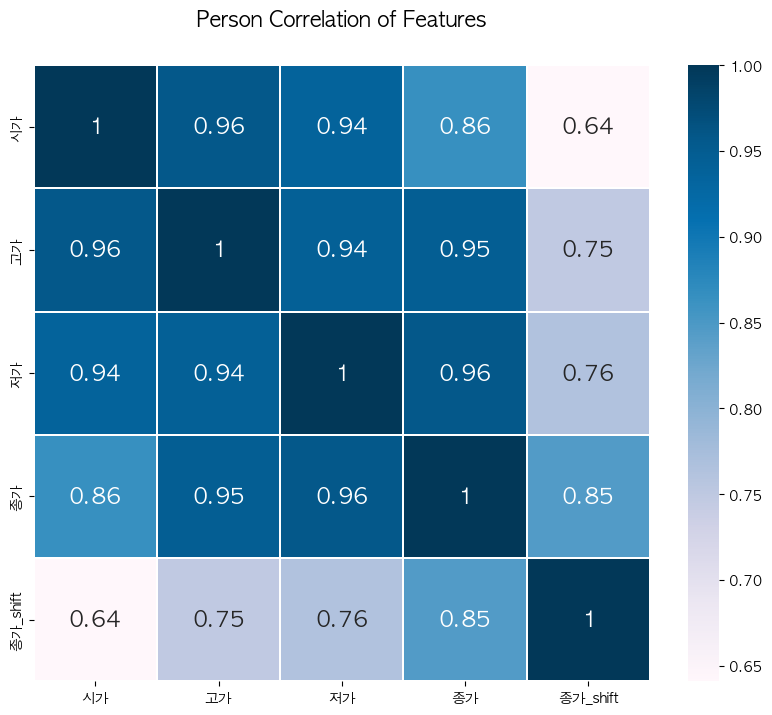

In [11]:
heatmap_data= candle_df_copy[['시가', '고가', '저가', '종가', '종가_shift']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [12]:
feature= candle_df_copy[['시가', '고가', '저가','종가']]
target= candle_df_copy[['종가_shift']]

# feature, target 데이터 스케일링
scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

In [13]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (468, 4) (468, 1)
테스트 데이터의 크기 : (117, 4) (117, 1)


In [14]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(train_X, train_y)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.5}
최고 예측 정확도: 0.7634


In [15]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(train_X, train_y)

# XGBoost 모델을 평가한다
y_pred = xgb.predict(test_X)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(test_y, y_pred)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(test_y, y_pred))


XGBoost 모델의 RMSE: 0.11025250038706835
XGBoost 모델의 r2_score: 0.5552292377278538


In [16]:
# 모델 저장
pickle.dump(xgb, open('model/price_candle_XGBoost_static_10days.pkl', 'wb'))

# scaler 저장
pickle.dump(scaler1, open('model/price_candle_XGBoost_static_10days_scaler1.pkl', 'wb'))
pickle.dump(scaler2, open('model/price_candle_XGBoost_static_10days_scaler2.pkl', 'wb'))


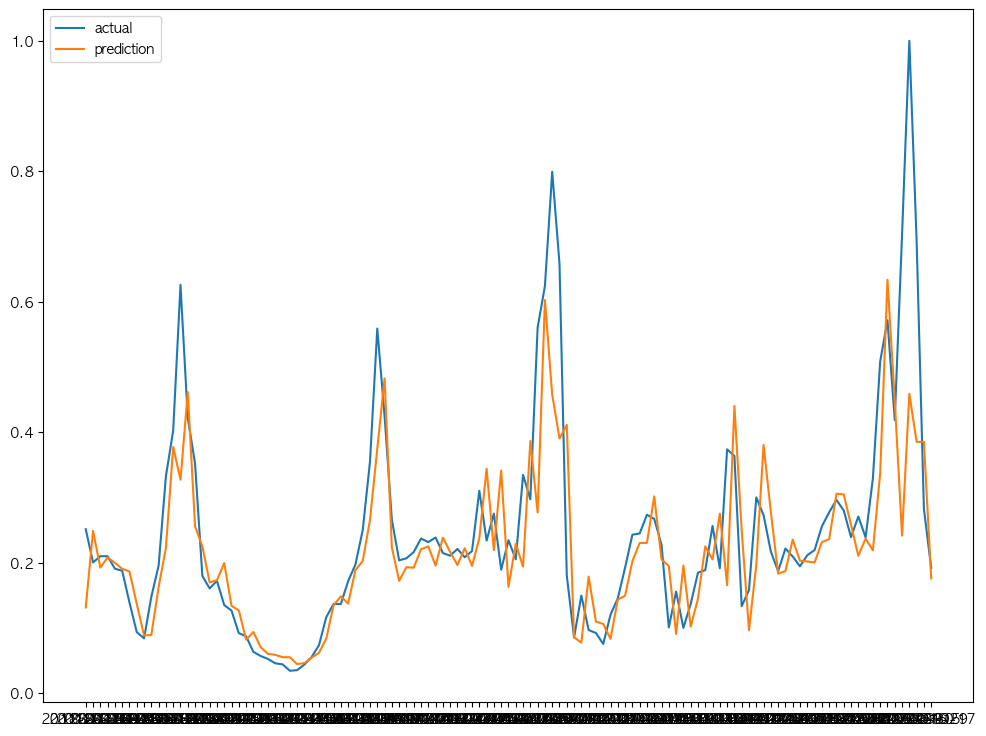

In [17]:
# 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_y, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()




Make new data

In [18]:
candle_df_last

,시가,고가,저가,종가
날짜,,,,
2022-10-31,9706.0,9706.0,7792.5,7792.5


In [19]:
model = pickle.load(open('model/price_candle_XGBoost_static_10days.pkl', 'rb'))
scaler1 = pickle.load(open('model/price_candle_XGBoost_static_10days_scaler1.pkl', 'rb'))
scaler2 = pickle.load(open('model/price_candle_XGBoost_static_10days_scaler2.pkl', 'rb'))

# model predict using test_data
test_data_sc = scaler1.transform(candle_df_last)
test_data_sc = pd.DataFrame(test_data_sc, columns=candle_df_last.columns, index=candle_df_last.index)
y_pred = model.predict(test_data_sc)
# reshape
y_pred = y_pred.reshape(-1, 1)
# inverse transform
y_pred = scaler2.inverse_transform(y_pred)
y_pred

array([[6712.252]], dtype=float32)